# INSTRUCTIONS
* [RUN THIS KERNEL](https://www.kaggle.com/nazmuddhohaansary/gcspath-for-rice-leaf-9-class-data)
* Collect The GCS PATH: such as 

```'gs://kds-33dc5d420bc7282a4b7955000de5511010e42953a4fb70942d1b0112'```
* Set The GCS_PATH="The value we got"

In [1]:
GCS_PATH='gs://kds-3e43dc9051dbb77874e2b92bb0ceeeab3064049538e89c1d7d9d41d6' # @param

# Installations

In [2]:
from IPython.display import clear_output
!pip install -U image-classifiers
!pip install -U efficientnet
clear_output()

# Mount Drive 
* change working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/

/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis


In [5]:
ls -la

total 5
-rw------- 1 root root  249 Jan  7 08:38 config.json
drwx------ 2 root root 4096 Jan  7 08:37 models/


# PARAMETERS


In [6]:
import os 
GCS_PATH    =    'gs://kds-3e43dc9051dbb77874e2b92bb0ceeeab3064049538e89c1d7d9d41d6'
MODEL_NAME  =    "mobilenetv2" # @param ["vgg16", "vgg19", "EfficientNetB7", "vgg19","resnet18","resnet34","resnet50","resnet101","resnet152","resnet50v2","resnet101v2","resnet152v2","resnext50","resnext101","densenet121","densenet169","densenet201","inceptionv3","xception","inceptionresnetv2","seresnet18","seresnet34","seresnet50","seresnet101","seresnet152","seresnext50","seresnext101","senet154","nasnetlarge","nasnetmobile","mobilenet","mobilenetv2"]
DATA_FOLDER =    "content/drive/MyDrive/covid_19_pneumonia_tuberculosis/data/tfrecords"
EPOCHS      =    250   # @param
BUFFER_SIZE =    2048  
MODEL_DIR =    os.path.join(os.getcwd(),"models",f'{MODEL_NAME}') 

if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,f"{MODEL_NAME}.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}'
print(GCS_PATH)
print(WEIGHT_PATH)



gs://kds-3e43dc9051dbb77874e2b92bb0ceeeab3064049538e89c1d7d9d41d6/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/data/tfrecords
/content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/models/mobilenetv2/mobilenetv2.h5


# Config Reading

In [7]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['covid_19', 'normal', 'pneumonia', 'tuberculosis'],
 'nb_channels': 3,
 'nb_classes': 4,
 'nb_eval_data': 7194,
 'nb_train_data': 18180}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [8]:
import tensorflow as tf 
import os 


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.9.2
Running on TPU  grpc://10.7.61.26:8470


REPLICAS:  8


## Training Params

In [9]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

142 56


## Data input function

In [10]:
def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        
        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

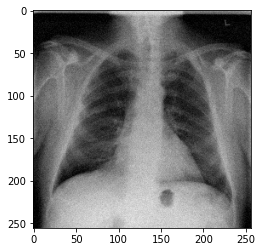

Exception ignored in: <function Executor.__del__ at 0x7efd8f3bd9d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 4)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])

# MODEL definition


## Callbacks
**CHANGABLE**

In [12]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]


In [13]:
from classification_models.tfkeras import Classifiers
import efficientnet.tfkeras as efn
with strategy.scope():
    if "EfficientNet" not in MODEL_NAME:
      classifier, _ = Classifiers.get(MODEL_NAME)
    else:
      classifier=getattr(efn,MODEL_NAME)
    net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False,weights="imagenet")
    # freeze layers
    for layer in net.layers:
      layer.trainable = False
    inp=net.input
    x=net.output
    # modeling
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
    model=tf.keras.Model(inputs=inp,outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )




model.summary()

/usr/local/lib/python3.8/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 257, 257, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                               

In [14]:
history = model.fit(train_ds,
                    steps_per_epoch= STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
141/142 [============================>.] - ETA: 0s - loss: 1.0805 - accuracy: 0.5250
Epoch 1: val_loss improved from inf to 1.03248, saving model to /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/models/mobilenetv2/mobilenetv2.h5
142/142 [==============================] - 74s 424ms/step - loss: 1.0788 - accuracy: 0.5262 - val_loss: 1.0325 - val_accuracy: 0.5497 - lr: 1.0000e-04
Epoch 2/250
141/142 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.7120
Epoch 2: val_loss improved from 1.03248 to 0.92052, saving model to /content/drive/MyDrive/covid_19_pneumonia_tuberculosis/local/covid_19_pneumonia_tuberculosis/models/mobilenetv2/mobilenetv2.h5
142/142 [==============================] - 8s 59ms/step - loss: 0.7673 - accuracy: 0.7121 - val_loss: 0.9205 - val_accuracy: 0.6081 - lr: 1.0000e-04
Epoch 3/250
142/142 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7624
Epoch 3: val_loss impro

## Model history

# Results



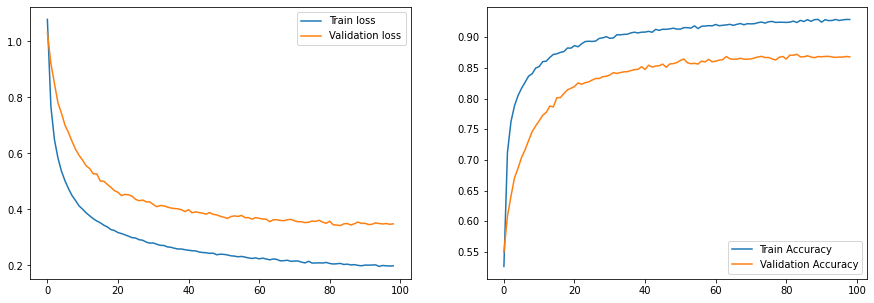

In [15]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig( os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [16]:
model.load_weights(WEIGHT_PATH)
test_ds   =   data_input_fn("test")
result = model.evaluate(test_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

56/56 [==============================] - 4s 28ms/step - loss: 0.1937 - accuracy: 0.9376


{'loss': 0.19365881383419037, 'accuracy': 0.9376395344734192}

In [17]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/56 [00:00<?, ?it/s]

4/4 [==============================] - 1s 21ms/step


Exception ignored in: <function Executor.__del__ at 0x7efd8f3bd9d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


# Saving

In [18]:
from sklearn.metrics import classification_report
report =classification_report(gts, preds, target_names=LABELS,output_dict=True)
report

{'covid_19': {'precision': 0.7549019607843137,
  'recall': 0.3333333333333333,
  'f1-score': 0.4624624624624625,
  'support': 231},
 'normal': {'precision': 0.8476972184222527,
  'recall': 0.8051104374187961,
  'f1-score': 0.8258551754775656,
  'support': 2309},
 'pneumonia': {'precision': 0.94086260560249,
  'recall': 0.9140388768898489,
  'f1-score': 0.9272567922874672,
  'support': 2315},
 'tuberculosis': {'precision': 0.8418445121951219,
  'recall': 0.9550367488110679,
  'f1-score': 0.894875430423334,
  'support': 2313},
 'accuracy': 0.8734654017857143,
 'macro avg': {'precision': 0.8463265742510446,
  'recall': 0.7518798491132616,
  'f1-score': 0.7776124651627072,
  'support': 7168},
 'weighted avg': {'precision': 0.8729071594524608,
  'recall': 0.8734654017857143,
  'f1-score': 0.8691650074945851,
  'support': 7168}}

In [19]:
import json
with open(os.path.join(MODEL_DIR,f"report_{MODEL_NAME}.json"), 'w') as fp:
    json.dump(report, fp)

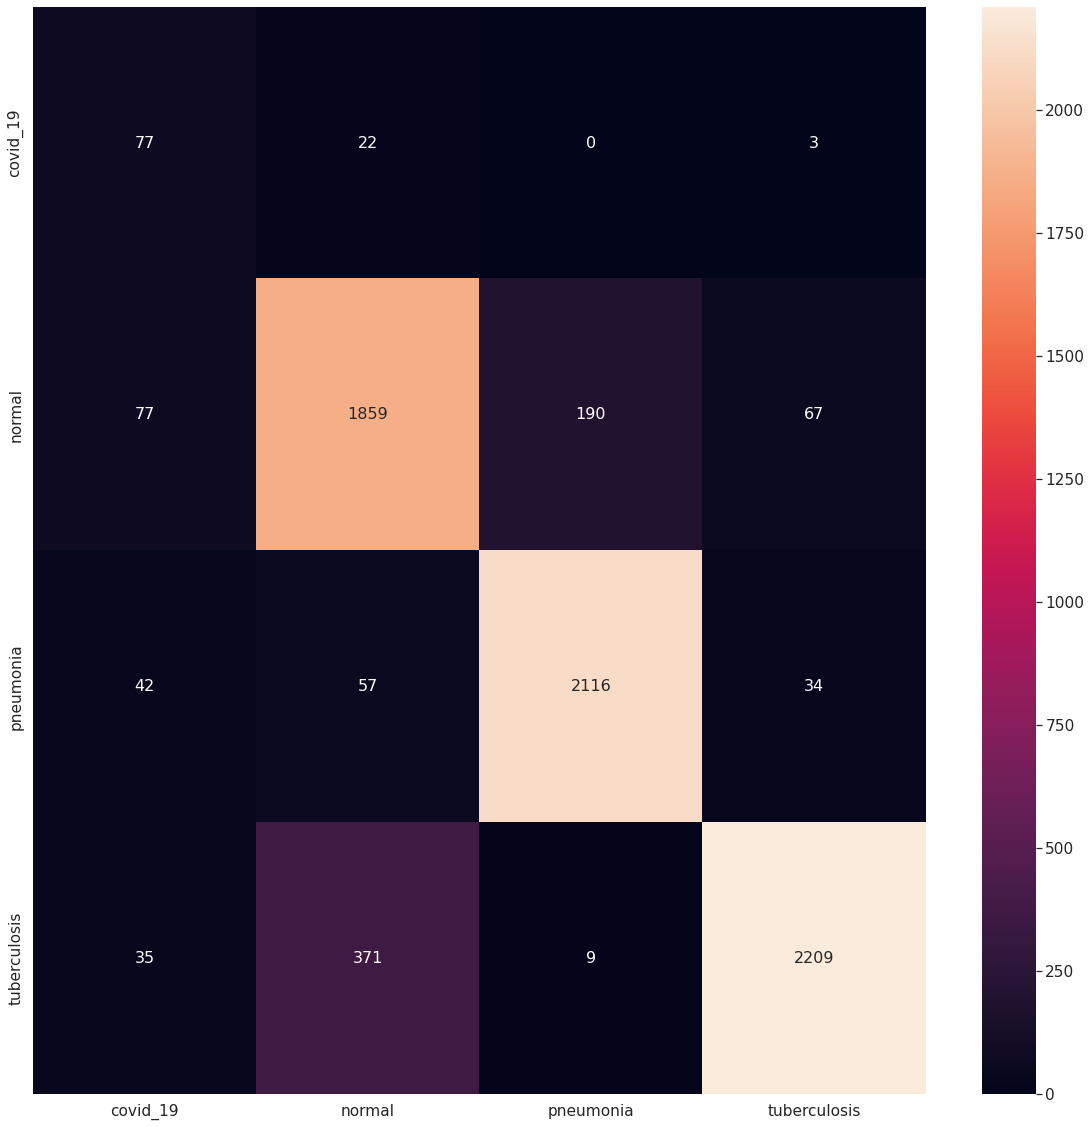

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat, 
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()